## Resources

In [1]:
PROJECT_ROOT_PATH = '../../../..'
TEMP_PATH = PROJECT_ROOT_PATH + '/tmp'
DATA_PATH = TEMP_PATH + '/detect/data'

WORDS_TRAIN_PATH = DATA_PATH + '/words.train.tsv'
WORDS_TEST_PATH = DATA_PATH + '/words.test.tsv'
LABELS_TRAIN_PATH = DATA_PATH + '/labels.train.tsv'
LABELS_TEST_PATH = DATA_PATH + '/labels.test.tsv'

import glob
FEATURES_TEST_PATH = sorted(glob.glob(DATA_PATH + "/*Feature*"))
FEATURES_TEST_PATH

['../../../../tmp/detect/data/ApproximateContextCoherenceFeature$bigram.tsv',
 '../../../../tmp/detect/data/ApproximateContextCoherenceFeature$fivegram.tsv',
 '../../../../tmp/detect/data/ApproximateContextCoherenceFeature$fourgram.tsv',
 '../../../../tmp/detect/data/ApproximateContextCoherenceFeature$trigram.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$123.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$124.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$125.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$126.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$127.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$32.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$33.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$34.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$35.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$36.tsv',
 '../../../../tmp/detect/dat

## Data

In [2]:
import csv
import pandas as pd

def read_words(path):
    col_names = ["w-4", "w-3", "w-2", "w-1", "w", "w+1", "w+2", "w+3", "pos"]
    return pd.read_table(open(path, 'r'),
                         header=None,
                         quoting=csv.QUOTE_NONE,
                         names=col_names,
                        )

def read_vals(path, name=None):
    return pd.read_table(open(path, 'r'),
                         header=None,
                         names=[name],
                        )

def read_labels(path):
    return read_vals(path, 'label')

def read_feat_vals(path):
    name = path[path[:-4].rfind('/') + 1:-4]
    return read_vals(path, name)

def read_feats(paths):
    feats_vals = [read_feat_vals(p) for p in paths]
    return pd.concat(feats_vals, axis=1)

WORDS_TRAIN = read_words(WORDS_TRAIN_PATH)
WORDS_TEST  = read_words(WORDS_TEST_PATH)
LABELS_TRAIN = read_labels(LABELS_TRAIN_PATH)
LABELS_TEST  = read_labels(LABELS_TEST_PATH)

feats = read_feats(FEATURES_TEST_PATH)
FEATS_TRAIN = feats[:WORDS_TRAIN.shape[0]]
FEATS_TEST = feats[WORDS_TRAIN.shape[0]:]
feats = None

## Evaluation

In [3]:
import os
import shutil
from sklearn import metrics
from sklearn.externals import joblib
import sys
import time

FORCE_RETRAIN = False
MODEL_PATH = TEMP_PATH + '/detect/model'

def get_pkl_path(name):
    return MODEL_PATH + '/' + '%s.pkl' % name

__train_time = {}  # cached training time

def train(models, retrain=False):
    if FORCE_RETRAIN:
        shutil.rmtree(MODEL_PATH)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    for (name, clf) in models:
        sys.stdout.write('%-30s ..... ' % name)
        pkl_path = get_pkl_path(name)
        if retrain or not os.path.exists(pkl_path):
            str_time = time.time()
            clf.fit(FEATS_TRAIN, LABELS_TRAIN.as_matrix().ravel())
            elapsed_time = (time.time() - str_time)
            joblib.dump(clf, pkl_path, compress=9)
            __train_time[name] = elapsed_time
            sys.stdout.write('TRAINED')
        else:
            elapsed_time = __train_time[name] if name in __train_time else None
            sys.stdout.write('SKIPPED') 
        if elapsed_time:
            sys.stdout.write(' (%.3f seconds)' % elapsed_time)
        print()

def test(models):
    for (name, _) in models:
        clf = joblib.load(get_pkl_path(name))
        preds = clf.predict(FEATS_TEST)
        acc = metrics.accuracy_score(LABELS_TEST, preds)
        print('%-30s ..... %.6f' % (name, acc))

def get_clf(name):
    return joblib.load(get_pkl_path(name))

### Evalutaion: Models without Optimization

In [4]:
from sklearn import ensemble
from sklearn import feature_selection
from sklearn import neural_network
from sklearn import neighbors
from sklearn import pipeline
from sklearn import tree
from sklearn import svm

MODELS_NO_OPT = [
    ['DTree', tree.DecisionTreeClassifier()],
    ['MLP', neural_network.MLPClassifier()],
    ['KNN', neighbors.KNeighborsClassifier()],
    ['RF', ensemble.RandomForestClassifier()],
    ['AdaBoost', ensemble.AdaBoostClassifier()],
    ['ETree', ensemble.ExtraTreesClassifier()],
    ['GradBoost', ensemble.GradientBoostingClassifier()],
    ['svc', svm.SVC()],
]

In [5]:
train(MODELS_NO_OPT)

DTree                          ..... SKIPPED
MLP                            ..... SKIPPED
KNN                            ..... SKIPPED
RF                             ..... SKIPPED
AdaBoost                       ..... SKIPPED
ETree                          ..... SKIPPED
GradBoost                      ..... SKIPPED
svc                            ..... SKIPPED


In [6]:
test(MODELS_NO_OPT)

DTree                          ..... 0.980433
MLP                            ..... 0.983605
KNN                            ..... 0.983874
RF                             ..... 0.984304
AdaBoost                       ..... 0.983336
ETree                          ..... 0.984142
GradBoost                      ..... 0.984035
svc                            ..... 0.983444


## Evalutaion: Grid-Search Model Selection

In [59]:
import numpy as np
from sklearn import model_selection

def model_selection_GridSearchCV(clf, param_grid):
    return model_selection.GridSearchCV(clf,
            param_grid=param_grid,
            cv=10,
            n_jobs=-1,
            scoring='accuracy')
MODELS_GSCV = [
    # SVC (RBF kernel)
    ['GSCV-SVC-rbf', model_selection_GridSearchCV(svm.SVC(kernel='rbf'),
        {'C': [1e0, 1e1, 1e2],
         'gamma': np.logspace(-2, 2, 5)
        }
    )],
    
    ['GSCV-RF', model_selection_GridSearchCV(ensemble.RandomForestClassifier(),
        {'n_estimators': np.arange(50, 250, 50),
         'min_samples_split': np.arange(2, 10)
        }
    )],
    ['GSCV-RF-2', model_selection_GridSearchCV(
        ensemble.RandomForestClassifier(
            oob_score=True,
            bootstrap=True,
        ),
        {'n_estimators': np.arange(100, 500, 100),
         'max_features': ['sqrt', None],
         'class_weight': ['balanced', 'balanced_subsample', None],
        }
    )],
    ['GSCV-RF-3', model_selection_GridSearchCV(
        ensemble.RandomForestClassifier(
            oob_score=True,
            bootstrap=True,
        ),
        {'n_estimators': np.arange(100, 1000, 50),
         'max_features': ['log2', 'sqrt', None],
         'min_samples_split': np.arange(2, 10)
        }
    )],
    
    # Gradient Boosting Trees
    ['GSCV-GradBoost', model_selection_GridSearchCV(ensemble.GradientBoostingClassifier(),
        {'n_estimators': np.arange(50, 250, 50),
         'min_samples_split': np.arange(2, 10)
        }
    )],
    ['GSCV-GradBoost-2', model_selection_GridSearchCV(ensemble.GradientBoostingClassifier(),
        {'n_estimators': np.arange(100, 1000, 100),
         'max_features': ['sqrt', None],
         'subsample': [0.25, 0.5, 0.75, 1],
        }
    )],
    
    # Extra Trees Classifier
    ['GSCV-ETree', model_selection_GridSearchCV(ensemble.ExtraTreesClassifier(),
        {'n_estimators': np.arange(50, 250, 50),
         'min_samples_split': np.arange(2, 10)
        }
    )],
    ['GSCV-ETree-2', model_selection_GridSearchCV(
        ensemble.ExtraTreesClassifier(
            oob_score=True,
            bootstrap=True,
        ),
        {'n_estimators': np.arange(100, 500, 100),
         'max_features': ['sqrt', None],
         'class_weight': ['balanced', 'balanced_subsample', None],
        }
    )],
    ['GSCV-ETree-3', model_selection_GridSearchCV(
        ensemble.ExtraTreesClassifier(
            oob_score=True,
            bootstrap=True,
            max_depth=None,
        ),
        {'n_estimators': np.arange(100, 500, 100),
         'max_features': ['sqrt', None],
        }
    )],
    ['GSCV-ETree-4', model_selection_GridSearchCV(
        ensemble.ExtraTreesClassifier(
            oob_score=True,
            bootstrap=True,
        ),
        {'n_estimators': np.arange(100, 500, 100),
         'max_features': ['sqrt', None],
         'max_depth': np.arange(2, 5)
        }
    )],
    ['GSCV-ETree-5', model_selection_GridSearchCV(
        ensemble.ExtraTreesClassifier(
            oob_score=True,
            bootstrap=True,
        ),
        {'n_estimators': np.arange(100, 500, 100),
         'max_features': ['sqrt', None],
         'max_depth': np.arange(5, 10)
        }
    )],
    ['GSCV-ETree-full-sqrt', model_selection_GridSearchCV(
        ensemble.ExtraTreesClassifier(
            oob_score=True,
            bootstrap=True,
            max_features='sqrt',
        ),
        {'n_estimators': np.arange(100, 1000, 100),
        }
    )],
    ['GSCV-ETree-full-all', model_selection_GridSearchCV(
        ensemble.ExtraTreesClassifier(
            oob_score=True,
            bootstrap=True,
            max_features=None,
        ),
        {'n_estimators': np.arange(100, 1000, 100),
        }
    )],
]

In [57]:
np.arange(2, 5)

array([2, 3, 4])

In [60]:
train(MODELS_GSCV)

GSCV-SVC-rbf                   ..... SKIPPED
GSCV-RF                        ..... SKIPPED
GSCV-RF-2                      ..... SKIPPED (1353.821 seconds)
GSCV-RF-3                      ..... SKIPPED (41279.582 seconds)
GSCV-GradBoost                 ..... SKIPPED
GSCV-GradBoost-2               ..... SKIPPED (1963.795 seconds)
GSCV-ETree                     ..... SKIPPED
GSCV-ETree-2                   ..... SKIPPED
GSCV-ETree-2                   ..... SKIPPED
GSCV-ETree-3                   ..... TRAINED (234.378 seconds)
GSCV-ETree-4                   ..... TRAINED (246.198 seconds)
GSCV-ETree-5                   ..... TRAINED (637.929 seconds)
GSCV-ETree-full-sqrt           ..... SKIPPED
GSCV-ETree-full-all            ..... SKIPPED


In [61]:
test(MODELS_GSCV)

GSCV-SVC-rbf                   ..... 0.983766
GSCV-RF                        ..... 0.984357
GSCV-RF-2                      ..... 0.984519
GSCV-RF-3                      ..... 0.984196
GSCV-GradBoost                 ..... 0.983981
GSCV-GradBoost-2               ..... 0.983820
GSCV-ETree                     ..... 0.984572
GSCV-ETree-2                   ..... 0.984519
GSCV-ETree-2                   ..... 0.984519
GSCV-ETree-3                   ..... 0.984519
GSCV-ETree-4                   ..... 0.983766
GSCV-ETree-5                   ..... 0.983927
GSCV-ETree-full-sqrt           ..... 0.984411
GSCV-ETree-full-all            ..... 0.984304


In [62]:
clf_names = [
    'GSCV-RF',
    'GSCV-RF-2',
    'GSCV-RF-3',
    'GSCV-GradBoost',
    'GSCV-GradBoost-2',
    'GSCV-ETree',
    'GSCV-ETree-2',
    'GSCV-ETree-3',
    'GSCV-ETree-4',
    'GSCV-ETree-5',
    'GSCV-ETree-full-sqrt',
    'GSCV-ETree-full-all',
    ]
for name in clf_names:
    clf = get_clf(name).best_estimator_
    try:
        print(name, ': ', clf.oob_score_)
    except AttributeError:
        print(name)
    print(clf)
    print()

GSCV-RF
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

GSCV-RF-2 :  0.987921774524
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

GSCV-RF-3 :  0.988355290094
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity

## Evalutaion: Tree-Based Feature Selection

In [36]:
import numpy as np
import matplotlib.pyplot as plt
 
def get_mean_importance(clf):
    importances = clf.feature_importances_
    return sum(importances) / FEATS_TEST.shape[1]

def get_char(feat_name):
    if 'CharacterExistenceFeature' not in feat_name:
        raise Exception('Given feature is not an CharacterExistenceFeature.')
    return chr(int(feat_name[26:]))

def get_feat_name(feat_name):
    """ Return the feature name. If the given name is an CharacterExistenceFeature, include
    the character name.
    """
    if 'CharacterExistenceFeature' in feat_name:
        return '%s (%s)'% (feat_name, get_char(feat_name))
    else:
        return feat_name

def eval_feat_importances(clf):
    if isinstance(clf, model_selection.GridSearchCV):
        clf = clf.best_estimator_
    importances = clf.feature_importances_
    if isinstance(clf, ensemble.GradientBoostingClassifier):
        std = np.std([tree[0].feature_importances_ for tree in clf.estimators_], axis=0)
    else:
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    print(type(clf).__name__)
    print()
    
    print(get_mean_importance(clf))

    # Plot importance
    plt.figure(figsize=(14,5))
    plt.title('Tree-based feature importances')
    plt.bar(range(FEATS_TRAIN.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(FEATS_TRAIN.shape[1]), indices)
    plt.xlim([-1, FEATS_TRAIN.shape[1]])
    plt.show()

    # Print importance rank
    print("Feature ranking:")
    for f in range(FEATS_TRAIN.shape[1]):
        print("%2d. %-50s (%f)"
              % (f + 1, get_feat_name(FEATS_TRAIN.columns[indices[f]]),
                 importances[indices[f]]))

RandomForestClassifier

0.0238095238095


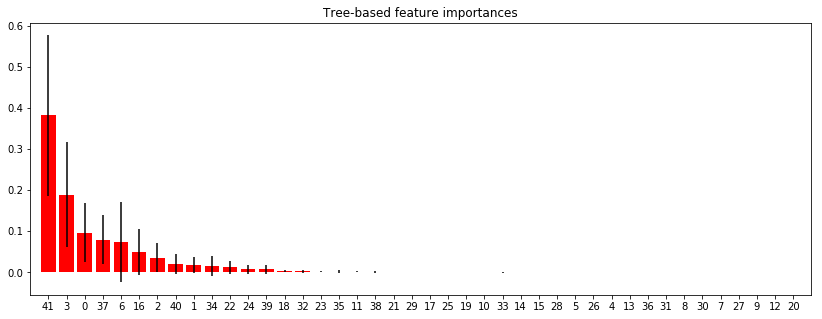

Feature ranking:
 1. WordValidityFeature                                (0.381836)
 2. ApproximateContextCoherenceFeature$trigram         (0.188405)
 3. ApproximateContextCoherenceFeature$bigram          (0.096584)
 4. ContextCoherenceFeature$bigram                     (0.079554)
 5. CharacterExistenceFeature$125 (})                  (0.073321)
 6. CharacterExistenceFeature$39 (')                   (0.049197)
 7. ApproximateContextCoherenceFeature$fourgram        (0.035205)
 8. ContextCoherenceFeature$trigram                    (0.021124)
 9. ApproximateContextCoherenceFeature$fivegram        (0.018005)
10. CharacterExistenceFeature$94 (^)                   (0.015129)
11. CharacterExistenceFeature$45 (-)                   (0.011830)
12. CharacterExistenceFeature$47 (/)                   (0.007077)
13. ContextCoherenceFeature$fourgram                   (0.006920)
14. CharacterExistenceFeature$41 ())                   (0.002887)
15. CharacterExistenceFeature$92 (\)                   (0.0

In [37]:
eval_feat_importances(get_clf('GSCV-RF'))

RandomForestClassifier

0.0238095238095


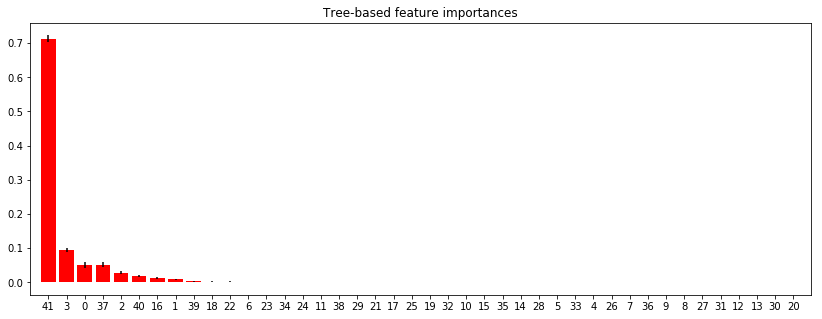

Feature ranking:
 1. WordValidityFeature                                (0.712972)
 2. ApproximateContextCoherenceFeature$trigram         (0.094789)
 3. ApproximateContextCoherenceFeature$bigram          (0.051231)
 4. ContextCoherenceFeature$bigram                     (0.050993)
 5. ApproximateContextCoherenceFeature$fourgram        (0.028207)
 6. ContextCoherenceFeature$trigram                    (0.019035)
 7. CharacterExistenceFeature$39 (')                   (0.012946)
 8. ApproximateContextCoherenceFeature$fivegram        (0.009042)
 9. ContextCoherenceFeature$fourgram                   (0.003327)
10. CharacterExistenceFeature$41 ())                   (0.002459)
11. CharacterExistenceFeature$45 (-)                   (0.002305)
12. CharacterExistenceFeature$125 (})                  (0.002206)
13. CharacterExistenceFeature$46 (.)                   (0.001803)
14. CharacterExistenceFeature$94 (^)                   (0.001340)
15. CharacterExistenceFeature$47 (/)                   (0.0

In [39]:
eval_feat_importances(get_clf('GSCV-RF-2'))

GradientBoostingClassifier

0.0238095238095


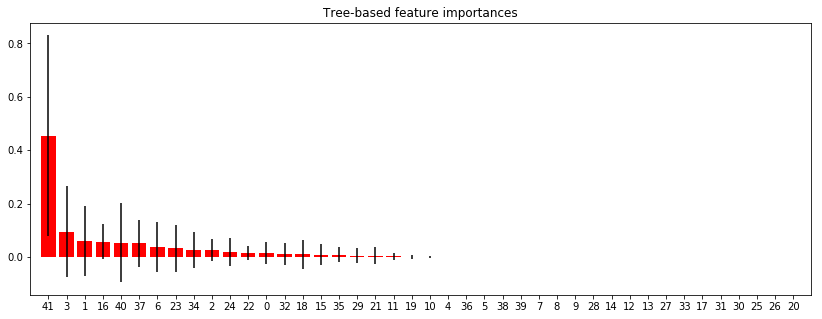

Feature ranking:
 1. WordValidityFeature                                (0.454334)
 2. ApproximateContextCoherenceFeature$trigram         (0.095107)
 3. ApproximateContextCoherenceFeature$fivegram        (0.060504)
 4. CharacterExistenceFeature$39 (')                   (0.058071)
 5. ContextCoherenceFeature$trigram                    (0.053832)
 6. ContextCoherenceFeature$bigram                     (0.050877)
 7. CharacterExistenceFeature$125 (})                  (0.037389)
 8. CharacterExistenceFeature$46 (.)                   (0.032149)
 9. CharacterExistenceFeature$94 (^)                   (0.027946)
10. ApproximateContextCoherenceFeature$fourgram        (0.025495)
11. CharacterExistenceFeature$47 (/)                   (0.019845)
12. CharacterExistenceFeature$45 (-)                   (0.016444)
13. ApproximateContextCoherenceFeature$bigram          (0.014287)
14. CharacterExistenceFeature$92 (\)                   (0.011984)
15. CharacterExistenceFeature$41 ())                   (0.0

In [40]:
eval_feat_importances(get_clf('GSCV-GradBoost'))

GradientBoostingClassifier

0.0238095238095


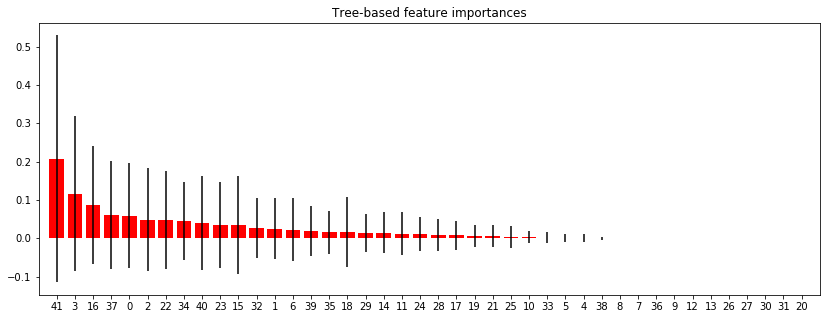

Feature ranking:
 1. WordValidityFeature                                (0.207071)
 2. ApproximateContextCoherenceFeature$trigram         (0.116331)
 3. CharacterExistenceFeature$39 (')                   (0.087629)
 4. ContextCoherenceFeature$bigram                     (0.060784)
 5. ApproximateContextCoherenceFeature$bigram          (0.058215)
 6. ApproximateContextCoherenceFeature$fourgram        (0.048491)
 7. CharacterExistenceFeature$45 (-)                   (0.047312)
 8. CharacterExistenceFeature$94 (^)                   (0.044734)
 9. ContextCoherenceFeature$trigram                    (0.039135)
10. CharacterExistenceFeature$46 (.)                   (0.034916)
11. CharacterExistenceFeature$38 (&)                   (0.034822)
12. CharacterExistenceFeature$92 (\)                   (0.027514)
13. ApproximateContextCoherenceFeature$fivegram        (0.025411)
14. CharacterExistenceFeature$125 (})                  (0.022700)
15. ContextCoherenceFeature$fourgram                   (0.0

In [41]:
eval_feat_importances(get_clf('GSCV-GradBoost-2'))

ExtraTreesClassifier

0.0238095238095


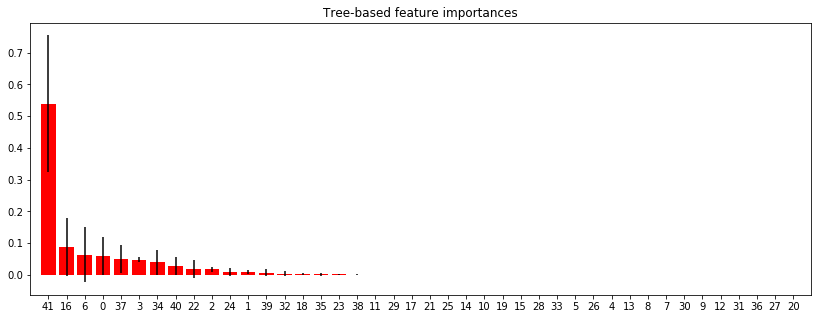

Feature ranking:
 1. WordValidityFeature                                (0.539270)
 2. CharacterExistenceFeature$39 (')                   (0.088932)
 3. CharacterExistenceFeature$125 (})                  (0.063202)
 4. ApproximateContextCoherenceFeature$bigram          (0.059427)
 5. ContextCoherenceFeature$bigram                     (0.050783)
 6. ApproximateContextCoherenceFeature$trigram         (0.048300)
 7. CharacterExistenceFeature$94 (^)                   (0.039465)
 8. ContextCoherenceFeature$trigram                    (0.028295)
 9. CharacterExistenceFeature$45 (-)                   (0.019322)
10. ApproximateContextCoherenceFeature$fourgram        (0.017449)
11. CharacterExistenceFeature$47 (/)                   (0.009665)
12. ApproximateContextCoherenceFeature$fivegram        (0.009635)
13. ContextCoherenceFeature$fourgram                   (0.007489)
14. CharacterExistenceFeature$92 (\)                   (0.004143)
15. CharacterExistenceFeature$41 ())                   (0.0

In [42]:
eval_feat_importances(get_clf('GSCV-ETree').best_estimator_)

ExtraTreesClassifier

0.0238095238095


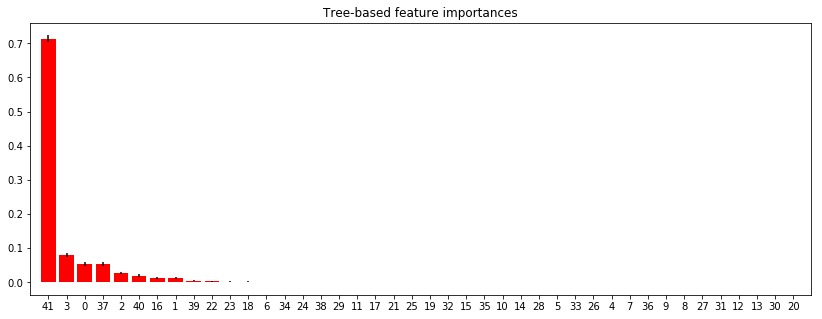

Feature ranking:
 1. WordValidityFeature                                (0.713604)
 2. ApproximateContextCoherenceFeature$trigram         (0.080500)
 3. ApproximateContextCoherenceFeature$bigram          (0.054671)
 4. ContextCoherenceFeature$bigram                     (0.054327)
 5. ApproximateContextCoherenceFeature$fourgram        (0.027978)
 6. ContextCoherenceFeature$trigram                    (0.020013)
 7. CharacterExistenceFeature$39 (')                   (0.012860)
 8. ApproximateContextCoherenceFeature$fivegram        (0.012265)
 9. ContextCoherenceFeature$fourgram                   (0.005233)
10. CharacterExistenceFeature$45 (-)                   (0.002728)
11. CharacterExistenceFeature$46 (.)                   (0.002623)
12. CharacterExistenceFeature$41 ())                   (0.002288)
13. CharacterExistenceFeature$125 (})                  (0.002156)
14. CharacterExistenceFeature$94 (^)                   (0.001361)
15. CharacterExistenceFeature$47 (/)                   (0.0

In [43]:
eval_feat_importances(get_clf('GSCV-ETree-2').best_estimator_)

ExtraTreesClassifier

0.0238095238095


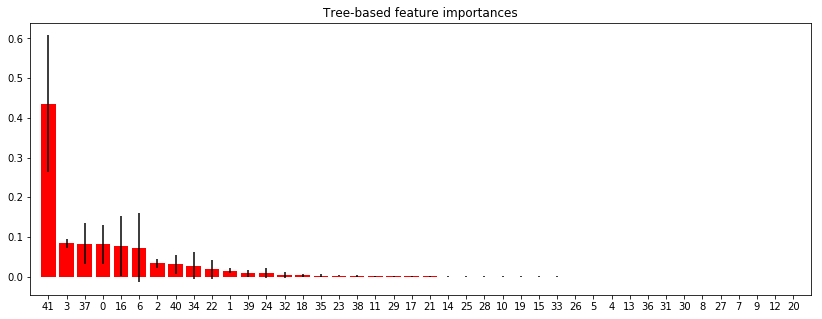

Feature ranking:
 1. WordValidityFeature                                (0.435538)
 2. ApproximateContextCoherenceFeature$trigram         (0.084082)
 3. ContextCoherenceFeature$bigram                     (0.083581)
 4. ApproximateContextCoherenceFeature$bigram          (0.081451)
 5. CharacterExistenceFeature$39 (')                   (0.077320)
 6. CharacterExistenceFeature$125 (})                  (0.073511)
 7. ApproximateContextCoherenceFeature$fourgram        (0.033446)
 8. ContextCoherenceFeature$trigram                    (0.030928)
 9. CharacterExistenceFeature$94 (^)                   (0.028173)
10. CharacterExistenceFeature$45 (-)                   (0.018425)
11. ApproximateContextCoherenceFeature$fivegram        (0.014771)
12. ContextCoherenceFeature$fourgram                   (0.009153)
13. CharacterExistenceFeature$47 (/)                   (0.009139)
14. CharacterExistenceFeature$92 (\)                   (0.004279)
15. CharacterExistenceFeature$41 ())                   (0.0

In [44]:
eval_feat_importances(get_clf('GSCV-ETree-full-sqrt').best_estimator_)

ExtraTreesClassifier

0.0238095238095


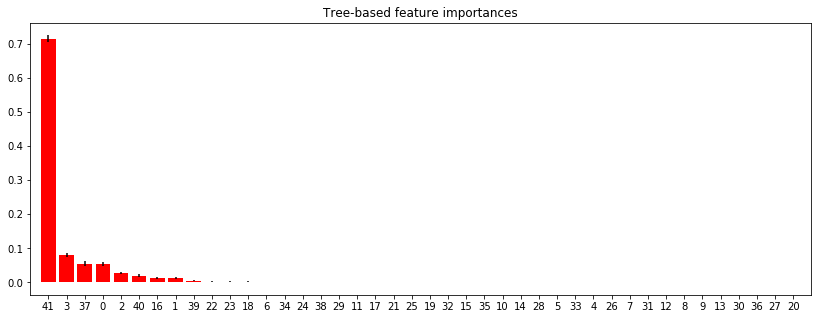

Feature ranking:
 1. WordValidityFeature                                (0.714632)
 2. ApproximateContextCoherenceFeature$trigram         (0.079641)
 3. ContextCoherenceFeature$bigram                     (0.055117)
 4. ApproximateContextCoherenceFeature$bigram          (0.053196)
 5. ApproximateContextCoherenceFeature$fourgram        (0.027748)
 6. ContextCoherenceFeature$trigram                    (0.020149)
 7. CharacterExistenceFeature$39 (')                   (0.013176)
 8. ApproximateContextCoherenceFeature$fivegram        (0.012475)
 9. ContextCoherenceFeature$fourgram                   (0.005212)
10. CharacterExistenceFeature$45 (-)                   (0.002704)
11. CharacterExistenceFeature$46 (.)                   (0.002658)
12. CharacterExistenceFeature$41 ())                   (0.002267)
13. CharacterExistenceFeature$125 (})                  (0.002130)
14. CharacterExistenceFeature$94 (^)                   (0.001309)
15. CharacterExistenceFeature$47 (/)                   (0.0

In [45]:
eval_feat_importances(get_clf('GSCV-ETree-full-all').best_estimator_)

In [46]:
from sklearn import model_selection
from sklearn import feature_selection

def feature_selection_RFECV(clf_name):
    clf = get_clf(clf_name)
    if isinstance(clf, model_selection.GridSearchCV):
        clf = clf.best_estimator_
    return feature_selection.RFECV(estimator=clf, cv=10, n_jobs=-1, scoring='accuracy')

MODELS_FEAT_OPT_TREE = [
    ['SFM-RF.RF', pipeline.Pipeline([
        ('SFM_RF', feature_selection.SelectFromModel(get_clf('RF'))),
        ('RF', ensemble.RandomForestClassifier()),
        ])
    ],
    ['SFM-RF-d5mean.RF', pipeline.Pipeline([
        ('SFM_RF', feature_selection.SelectFromModel(
            get_clf('RF'),
            threshold=get_mean_importance(get_clf('RF')) * 0.5)),
        ('RF', ensemble.RandomForestClassifier()),
        ])
    ],
    ['SFM-RF-d1mean.RF', pipeline.Pipeline([
        ('SFM_RF', feature_selection.SelectFromModel(
            get_clf('RF'),
            threshold=get_mean_importance(get_clf('RF')) * 0.1)),
        ('RF', ensemble.RandomForestClassifier()),
        ])
    ],
    ['SFM-AdaBoost.AdaBoost', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(get_clf('AdaBoost'))),
        ('AdaBoost', ensemble.AdaBoostClassifier()),
        ])
    ],
    ['SFM-AdaBoost-d5mean.AdaBoost', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(
            get_clf('AdaBoost'),
            threshold=get_mean_importance(get_clf('AdaBoost')) * 0.5)),
        ('AdaBoost', ensemble.AdaBoostClassifier()),
        ])
    ],
    ['SFM-AdaBoost-d1mean.AdaBoost', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(
            get_clf('AdaBoost'),
            threshold=get_mean_importance(get_clf('AdaBoost')) * 0.1)),
        ('AdaBoost', ensemble.AdaBoostClassifier()),
        ])
    ],
    ['SFM-ETree.ETree', pipeline.Pipeline([
        ('SFM_ETree', feature_selection.SelectFromModel(get_clf('ETree'))),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
    ['SFM-ETree-d5mean.ETree', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(
            get_clf('ETree'),
            threshold=get_mean_importance(get_clf('ETree')) * 0.5)),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
    ['SFM-ETree-d1mean.ETree', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(
            get_clf('ETree'),
            threshold=get_mean_importance(get_clf('ETree')) * 0.1)),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
    ['RFECV-ETree', feature_selection_RFECV('ETree')
    ],
    ['RFECV-ETree.ETree', pipeline.Pipeline([
        ('SFM_ETree', feature_selection_RFECV('ETree')),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
    ['RFECV-GSCV-ETree.ETree', pipeline.Pipeline([
        ('SFM_ETree', feature_selection_RFECV('GSCV-ETree')),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
    ['RFECV-GSCV-ETree.GSCV-ETree', pipeline.Pipeline([
        ('SFM_ETree', feature_selection_RFECV('GSCV-ETree')),
        ('GSCV_ETree', model_selection_GridSearchCV(ensemble.ExtraTreesClassifier(), {
            'n_estimators': np.arange(50, 250, 50),
            'min_samples_split': np.arange(2, 10),
            })),
        ])
    ],
#     ['RFECV-GSCV-ETree-full-all.GSCV-ETree', pipeline.Pipeline([
#         ('SFM_ETree', feature_selection_RFECV('GSCV-ETree-full-all')),
#         ('GSCV_ETree', model_selection_GridSearchCV(ensemble.ExtraTreesClassifier(), {
#             'n_estimators': np.arange(50, 250, 50),
#             'min_samples_split': np.arange(2, 10),
#             })),
#         ])
#     ],
    ['SFM-GradBoost.GradBoost', pipeline.Pipeline([
        ('SFM_BradBoost', feature_selection.SelectFromModel(get_clf('GradBoost'))),
        ('BradBoost', ensemble.GradientBoostingClassifier()),
        ])
    ],
    ['SFM-GradBoost-d5mean.GradBoost', pipeline.Pipeline([
        ('SFM_GradBoost', feature_selection.SelectFromModel(
            get_clf('GradBoost'),
            threshold=get_mean_importance(get_clf('GradBoost')) * 0.5)),
        ('ETree', ensemble.GradientBoostingClassifier()),
        ])
    ],
    ['SFM-GradBoost-d1mean.GradBoost', pipeline.Pipeline([
        ('SFM_GradBoost', feature_selection.SelectFromModel(
            get_clf('GradBoost'),
            threshold=get_mean_importance(get_clf('GradBoost')) * 0.1)),
        ('ETree', ensemble.GradientBoostingClassifier()),
        ])
    ],
    ['RFECV-GradBoost', feature_selection_RFECV('GradBoost')
    ],
    ['RFECV-GradBoost.GradBoost', pipeline.Pipeline([
        ('SFM_GradBoost', feature_selection_RFECV('GradBoost')),
        ('ETree', ensemble.GradientBoostingClassifier()),
        ])
    ],
]

In [47]:
train(MODELS_FEAT_OPT_TREE)

SFM-RF.RF                      ..... SKIPPED
SFM-RF-d5mean.RF               ..... SKIPPED
SFM-RF-d1mean.RF               ..... SKIPPED
SFM-AdaBoost.AdaBoost          ..... SKIPPED
SFM-AdaBoost-d5mean.AdaBoost   ..... SKIPPED
SFM-AdaBoost-d1mean.AdaBoost   ..... SKIPPED
SFM-ETree.ETree                ..... SKIPPED
SFM-ETree-d5mean.ETree         ..... SKIPPED
SFM-ETree-d1mean.ETree         ..... SKIPPED
RFECV-ETree                    ..... SKIPPED
RFECV-ETree.ETree              ..... SKIPPED
RFECV-GSCV-ETree.ETree         ..... SKIPPED
RFECV-GSCV-ETree.GSCV-ETree    ..... SKIPPED
SFM-GradBoost.GradBoost        ..... SKIPPED
SFM-GradBoost-d5mean.GradBoost ..... SKIPPED
SFM-GradBoost-d1mean.GradBoost ..... SKIPPED
RFECV-GradBoost                ..... SKIPPED
RFECV-GradBoost.GradBoost      ..... SKIPPED


In [48]:
test(MODELS_FEAT_OPT_TREE)

SFM-RF.RF                      ..... 0.984089
SFM-RF-d5mean.RF               ..... 0.984196
SFM-RF-d1mean.RF               ..... 0.984035
SFM-AdaBoost.AdaBoost          ..... 0.983229
SFM-AdaBoost-d5mean.AdaBoost   ..... 0.983336
SFM-AdaBoost-d1mean.AdaBoost   ..... 0.983336
SFM-ETree.ETree                ..... 0.984304
SFM-ETree-d5mean.ETree         ..... 0.984357
SFM-ETree-d1mean.ETree         ..... 0.984142
RFECV-ETree                    ..... 0.983659
RFECV-ETree.ETree              ..... 0.984250
RFECV-GSCV-ETree.ETree         ..... 0.984357
RFECV-GSCV-ETree.GSCV-ETree    ..... 0.984465
SFM-GradBoost.GradBoost        ..... 0.983659
SFM-GradBoost-d5mean.GradBoost ..... 0.983981
SFM-GradBoost-d1mean.GradBoost ..... 0.983981
RFECV-GradBoost                ..... 0.983766
RFECV-GradBoost.GradBoost      ..... 0.983659


In [49]:
get_clf('RFECV-GSCV-ETree.GSCV-ETree').steps[1].best_estimator_

AttributeError: 'tuple' object has no attribute 'best_estimator_'

In [50]:
import operator

def eval_opt_feats(rfecv):
    print('Optimal number of features : %d' % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross validation score (nb of correct classifications)')
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    ranked = [(k, v) for k, v in sorted(zip(FEATS_TRAIN.columns, rfecv.ranking_),
                                        key=operator.itemgetter(1))]
    for name, rank in ranked:
        sys.stdout.write('%2s. %s' % (rank, name))
        if 'CharacterExistenceFeature' in name:
            char = chr(int(name[26:]))
            sys.stdout.write(' ' + char)
        print()

Optimal number of features : 5


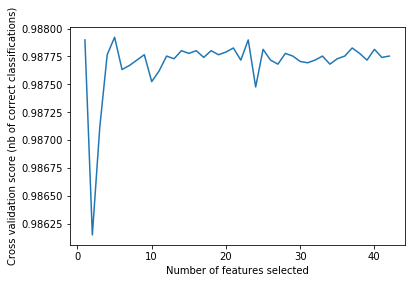

 1. ApproximateContextCoherenceFeature$bigram
 1. ApproximateContextCoherenceFeature$trigram
 1. CharacterExistenceFeature$39 '
 1. ContextCoherenceFeature$bigram
 1. WordValidityFeature
 2. CharacterExistenceFeature$125 }
 3. ApproximateContextCoherenceFeature$fourgram
 4. ContextCoherenceFeature$trigram
 5. ApproximateContextCoherenceFeature$fivegram
 6. CharacterExistenceFeature$45 -
 7. CharacterExistenceFeature$94 ^
 8. ContextCoherenceFeature$fourgram
 9. CharacterExistenceFeature$41 )
10. CharacterExistenceFeature$46 .
11. CharacterExistenceFeature$47 /
12. CharacterExistenceFeature$95 _
13. CharacterExistenceFeature$92 \
14. CharacterExistenceFeature$34 "
15. CharacterExistenceFeature$63 ?
16. CharacterExistenceFeature$40 (
17. CharacterExistenceFeature$44 ,
18. ContextCoherenceFeature$fivegram
19. CharacterExistenceFeature$59 ;
20. CharacterExistenceFeature$38 &
21. CharacterExistenceFeature$42 *
22. CharacterExistenceFeature$33 !
23. CharacterExistenceFeature$62 >
24. Charact

In [51]:
eval_opt_feats(get_clf('RFECV-ETree'))

Optimal number of features : 18


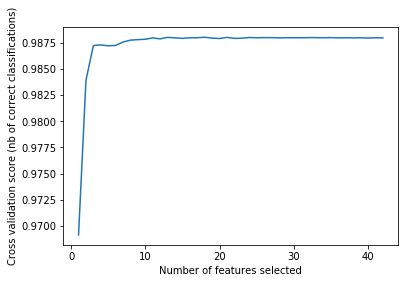

 1. ApproximateContextCoherenceFeature$bigram
 1. ApproximateContextCoherenceFeature$fivegram
 1. ApproximateContextCoherenceFeature$fourgram
 1. ApproximateContextCoherenceFeature$trigram
 1. CharacterExistenceFeature$125 }
 1. CharacterExistenceFeature$37 %
 1. CharacterExistenceFeature$38 &
 1. CharacterExistenceFeature$39 '
 1. CharacterExistenceFeature$45 -
 1. CharacterExistenceFeature$46 .
 1. CharacterExistenceFeature$47 /
 1. CharacterExistenceFeature$62 >
 1. CharacterExistenceFeature$92 \
 1. CharacterExistenceFeature$94 ^
 1. CharacterExistenceFeature$95 _
 1. ContextCoherenceFeature$bigram
 1. ContextCoherenceFeature$trigram
 1. WordValidityFeature
 2. CharacterExistenceFeature$63 ?
 3. ContextCoherenceFeature$fourgram
 4. CharacterExistenceFeature$44 ,
 5. CharacterExistenceFeature$124 |
 6. CharacterExistenceFeature$33 !
 7. CharacterExistenceFeature$41 )
 8. CharacterExistenceFeature$34 "
 9. CharacterExistenceFeature$40 (
10. CharacterExistenceFeature$42 *
11. Characte

In [52]:
eval_opt_feats(get_clf('RFECV-GradBoost'))

## Writeout Labels

In [63]:
CLF_NAME = 'GSCV-ETree'

In [68]:
LABEL_PATH = TEMP_PATH + '/detect/label'

if not os.path.exists(LABEL_PATH):
    os.makedirs(LABEL_PATH)
path = LABEL_PATH + '/labels.tsv'
clf = joblib.load(get_pkl_path(CLF_NAME))
labels = clf.predict(FEATS_TEST)
with open(path, 'w') as f:
    f.write('\n'.join(str(v) for v in preds))